<a href="https://colab.research.google.com/github/ozigbo/Foodconceptaggregationapi/blob/main/Another_copy_of_Deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This code below reads flower image data stored in Google Drive, where each subfolder corresponds to a flower category (e.g., daisy, rose, tulip). It preprocesses each image by resizing to 128×128 pixels and converting to RGB format to ensure consistency across the dataset. The script then stores each image along with its label for later use in training machine learning models. To verify the loading process, the first five images are visualized along with their corresponding labels. This preprocessing step is crucial for ensuring that all images have the same input dimensions for deep learning models such as Convolutional Neural Networks (CNNs).

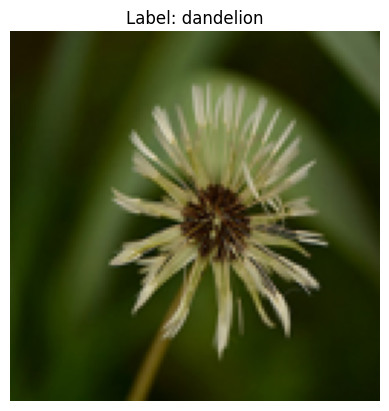

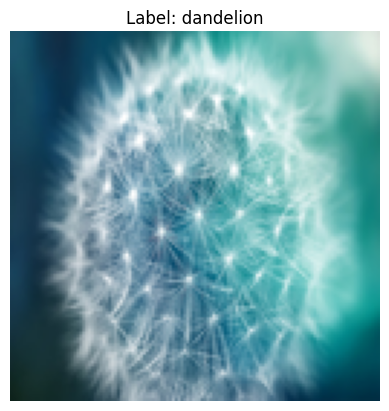

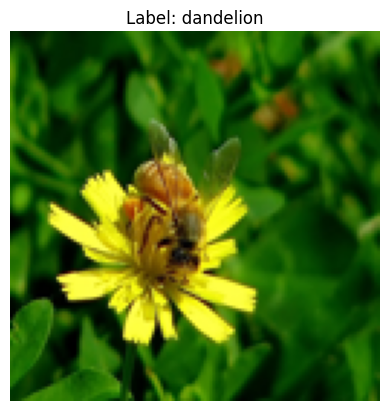

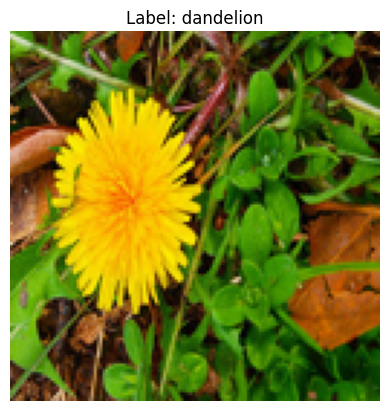

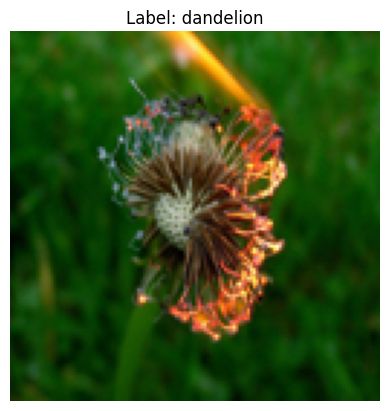

In [ ]:
"""
These libraries are used for:
Image loading and processing (PIL, matplotlib, os)
Deep learning (tensorflow.keras)
Data augmentation and performance evaluation (ImageDataGenerator, classification_report, etc.)
"""

from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import os
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

"""
This sets the path to the flower image dataset stored in Google Drive. Each subfolder in flowers is assumed to be a flower category (e.g., daisy, rose), and contains images of that flower.
"""
dataset_path = '/content/drive/My Drive/flowers'

"""
Here, two lists are initialized:
images will hold the image data.
labels will store the corresponding flower type for each image.
"""
images = []
labels = []

"""
Iterates through each flower type (folder).
For each image:
Opens and converts it to RGB (ensures 3 color channels).
Resizes it to 128x128 pixels (standard input size for CNNs).
Appends the processed image and its label to their respective lists.
Catches any errors during loading (e.g., corrupted files).
"""

for flower_type in os.listdir(dataset_path):
    flower_folder = os.path.join(dataset_path, flower_type)
    if os.path.isdir(flower_folder):
        for image_file in os.listdir(flower_folder):
            image_path = os.path.join(flower_folder, image_file)
            try:
                img = Image.open(image_path).convert("RGB").resize((128, 128))  # Resize for consistency
                images.append(img)
                labels.append(flower_type)
            except Exception as e:
                print(f"Error reading {image_path}: {e}")

"""
Loops through the first 5 images.
Displays them using matplotlib.
Shows their corresponding labels to help confirm the dataset is loaded correctly.
"""
for i in range(5):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
    plt.show()





The code below segment counts the number of images in each flower class and visualizes the distribution using a bar chart. It then identifies any imbalanced classes, defined as those with fewer than 80% of the image count of the most represented class. This helps ensure fairness in model training and reveals if any categories might need data augmentation or sampling strategies. Class imbalance can lead to biased models that favor dominant classes, so early detection and correction are essential in image classification tasks.

dandelion: 1052 images
sunflower: 733 images
daisy: 764 images
tulip: 984 images
rose: 784 images


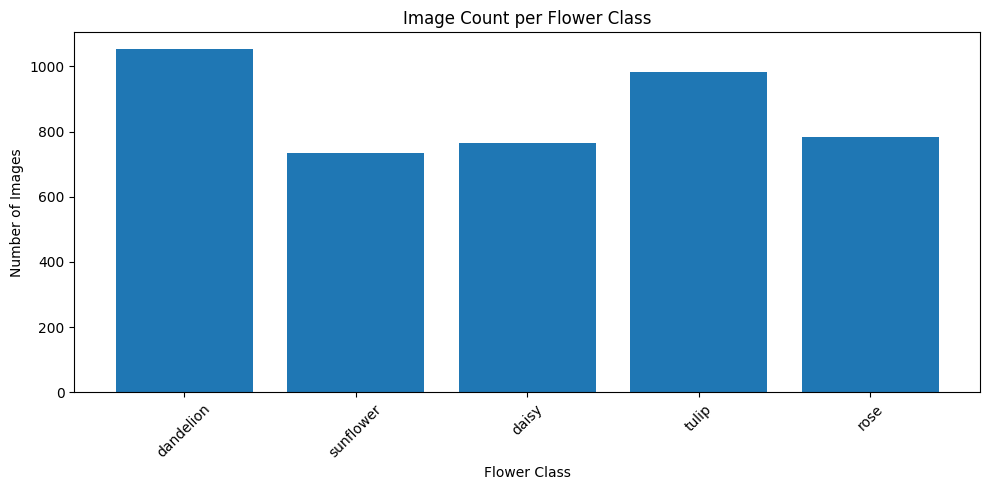


⚠️ Imbalanced Classes (less than 80% of largest class):
sunflower: 733 images
daisy: 764 images
rose: 784 images


In [ ]:
"""
This code analyzes class distribution in your flower dataset to:
Count how many images exist for each flower category.
Visualize the distribution using a bar chart.
Detect class imbalance, which can negatively affect model performance.
"""

"""
Creates a dictionary to count the number of images per class (flower type).
defaultdict(int) ensures all new keys start with a default value of 0.

Loops through each subfolder (flower class).

Filters files to include only valid image formats (.jpg, .jpeg, .png).

Counts the images for each flower type and updates the dictionary.
"""
class_counts = defaultdict(int)

for flower_type in os.listdir(dataset_path):
    flower_folder = os.path.join(dataset_path, flower_type)
    if os.path.isdir(flower_folder):
        num_images = len([
            file for file in os.listdir(flower_folder)
            if file.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        class_counts[flower_type] = num_images

# Prints out the number of images for each flower category.
for flower, count in class_counts.items():
    print(f"{flower}: {count} images")



"""Plots a bar chart to visualize how balanced the dataset is.

Each bar represents a flower type and its number of images.

rotation=45 tilts x-axis labels for better readability.
"""
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Image Count per Flower Class")
plt.xlabel("Flower Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"""
Finds the maximum image count among all flower types.
Sets an imbalance threshold at 80% of that max value.
"""
max_count = max(class_counts.values())
imbalance_threshold = 0.8 * max_count

# Creates a dictionary of flower classes that fall below the 80% threshold (i.e., underrepresented).

imbalanced_classes = {k: v for k, v in class_counts.items() if v < imbalance_threshold}

"""
Prints out which classes are imbalanced so you can take action, like:
Augmenting underrepresented classes.
Using class weights during model training.
Collecting more data.
"""

print("\n⚠️ Imbalanced Classes (less than 80% of largest class):")
for flower, count in imbalanced_classes.items():
    print(f"{flower}: {count} images")



This code implements a complete image classification pipeline using a Convolutional Neural Network (CNN) on a flower image dataset. The data is augmented with techniques such as rotation, zooming, and flipping to improve generalization. Class imbalance is handled using calculated class weights. A CNN model with three convolutional layers is trained using the Adam optimizer and categorical cross-entropy loss. After training, the model is evaluated using standard classification metrics, providing insights into how well it performs across all flower categories.

In [ ]:
# Data Preparation with Augmentation

# Sets the image size and the number of images processed per training batch.
img_height, img_width = 128, 128
batch_size = 32


"""
ImageDataGenerator is used for data augmentation to increase dataset diversity.
Operations include:
Rescaling: Normalize pixel values (0-255 → 0-1).
Rotation, zoom, shifting, flipping: Artificially diversify images.
Validation split: Automatically split data into training (80%) and validation (20%).
"""

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

"""
These load images from subfolders (each subfolder = one class).
They apply augmentation and convert labels to categorical format for multi-class classification.
"""
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


"""
Computes class weights to address class imbalance.
Ensures underrepresented classes are not ignored during training.
"""
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


# Converts the list into a dictionary keyed by class index for use in training.
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


"""
Defines a Sequential CNN model with:

1) Three convolution + pooling blocks: Detects patterns like edges, textures, and shapes.

2) Flattening layer: Converts 2D feature maps to 1D vector.

3) Dense layer with 128 neurons: Fully connected to learn complex features.

4) Dropout: Prevents overfitting by randomly ignoring 50% of neurons during training.

5) Final dense layer: Uses softmax to output class probabilities.

"""

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


# Adam optimizer is used for fast convergence. Categorical crossentropy is appropriate for multi-class classification.

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Prints the model architecture and parameter counts.
model.summary()

"""
Trains the model for 15 epochs.
Uses both training and validation sets.
Applies class weights to handle imbalanced datasets.
"""

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weights
)


"""
Predicts labels on validation data.
argmax converts predicted probabilities to class indices.
True labels are extracted from the generator
"""
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

"""
Converts class indices back to labels.
classification_report shows precision, recall, F1-score for each class.
"""
class_labels = list(val_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))



Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Class Weights: {0: np.float64(1.1297385620915033), 1: np.float64(0.8211401425178148), 2: np.float64(1.1009554140127389), 3: np.float64(1.1778534923339012), 4: np.float64(0.8774111675126903)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.3252 - loss: 1.4645 - val_accuracy: 0.5302 - val_loss: 1.1775
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5308 - loss: 1.1518 - val_accuracy: 0.5930 - val_loss: 1.0640
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.5965 - loss: 1.0271 - val_accuracy: 0.6256 - val_loss: 0.9895
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6075 - loss: 0.9880 - val_accuracy: 0.6430 - val_loss: 0.9179
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6384 - loss: 0.9201 - val_accuracy: 0.6523 - val_loss: 0.9169
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6393 - loss: 0.8902 - val_accuracy: 0.6605 - val_loss: 0.9119
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6592 - loss: 0.9163 - val_accuracy: 0.6384 - val_loss: 0.9407
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6942 - loss: 0.8230 - 

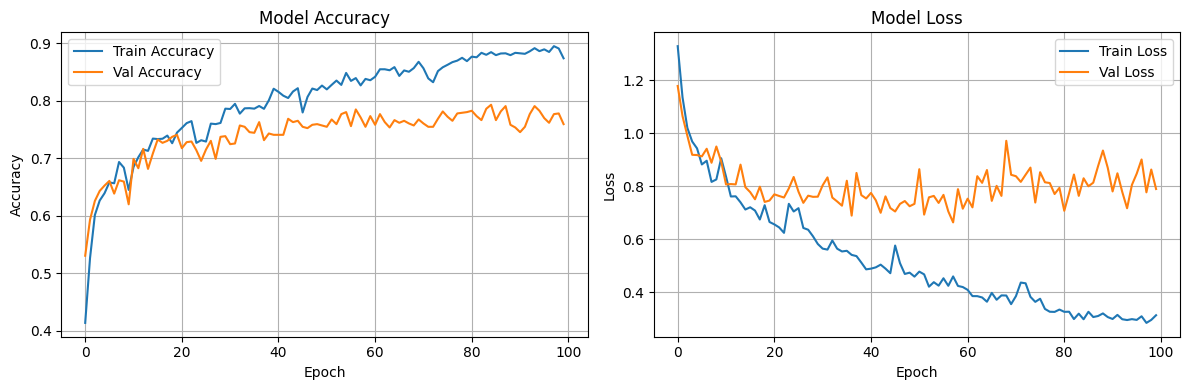

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


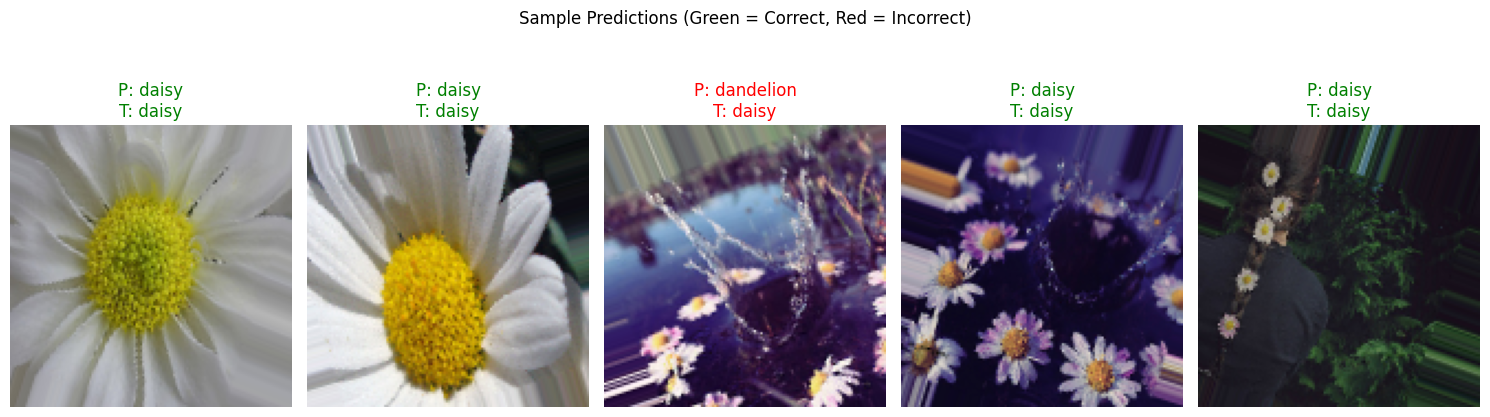

In [ ]:
# Predict a few validation images
val_generator.reset()
x_test, y_test = next(val_generator)

# Get class predictions
pred_probs = model.predict(x_test)
y_pred = np.argmax(pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
class_labels = list(val_generator.class_indices.keys())

# Display first 5 predictions
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    pred_label = class_labels[y_pred[i]]
    true_label = class_labels[y_true[i]]
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)

plt.suptitle("Sample Predictions (Green = Correct, Red = Incorrect)")
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

model.save('flower_classifier_model.h5')
print("Model saved successfully!")



model = load_model('flower_classifier_model.h5')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 545ms/step


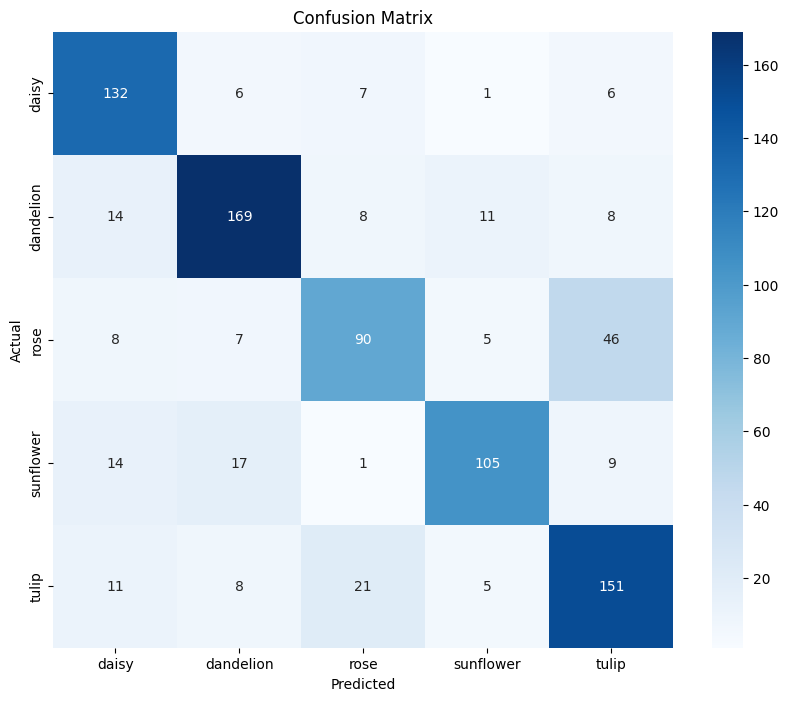

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on all validation data
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

